In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.multitest import NullDistribution
from statsmodels.stats.weightstats import ztest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,NuSVC
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
np.random.seed(31)
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load dataset
dataset = pd.read_csv('heart.csv')

In [3]:
#Clean dataset

x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values.reshape((-1,1))

# Taking care of missing data

# completing missing values in continous features

from sklearn.impute import SimpleImputer
imputer_x_continous = SimpleImputer(missing_values = np.nan,strategy='mean')
x[:,[0,3,4,7,9]] = imputer_x_continous.fit_transform(x[:,[0,3,4,7,9]])

# completing missing values in discerte features

imputer_x_Discrete = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
x[:,[1,2,5,6,8,10]] = imputer_x_Discrete.fit_transform(x[:,[1,2,5,6,8,10]])

# completing missing values in discerte  true values


imputer_y = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
y = imputer_y.fit_transform(y)

# Removing Outliers
def remove_outliers (x,y,feature_index):
    
    Q1 = np.quantile(x[:,feature_index],0.25)
    Q3 = np.quantile(x[:,feature_index],0.75)
    IQR = Q3 - Q1
    list =[]
    for i in range(x.shape[0]):
        if(x[i][feature_index] < Q1-1.5* IQR or x[i][feature_index] >Q3+1.5*IQR):
            list.append(i)
    list.reverse()
    for i in list:
        x = np.delete(x, (i), axis=0)
        y = np.delete(y,(i),axis =0)
    return x,y,list

# Remove for each feature
list1 =[0,3,4,7,9]
for j in list1:
    x,y,list2 =remove_outliers(x,y,j)

In [4]:
#Load cleaned dataset into a new dataframe
df = pd.DataFrame(np.append(x,y, axis = 1))
df.columns = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']

In [5]:
#Check for nulls and column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             701 non-null    object
 1   Sex             701 non-null    object
 2   ChestPainType   701 non-null    object
 3   RestingBP       701 non-null    object
 4   Cholesterol     701 non-null    object
 5   FastingBS       701 non-null    object
 6   RestingECG      701 non-null    object
 7   MaxHR           701 non-null    object
 8   ExerciseAngina  701 non-null    object
 9   Oldpeak         701 non-null    object
 10  ST_Slope        701 non-null    object
 11  HeartDisease    701 non-null    object
dtypes: object(12)
memory usage: 65.8+ KB


In [6]:
#Fix data frame types
df = df.astype({'Age': 'int64', 'RestingBP': 'int64', 'Cholesterol': 'int64', 'FastingBS': 'int64', 'MaxHR': 'int64', 'HeartDisease': 'int64', 'Oldpeak' : 'float64'})

In [7]:
#View cleaned dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             701 non-null    int64  
 1   Sex             701 non-null    object 
 2   ChestPainType   701 non-null    object 
 3   RestingBP       701 non-null    int64  
 4   Cholesterol     701 non-null    int64  
 5   FastingBS       701 non-null    int64  
 6   RestingECG      701 non-null    object 
 7   MaxHR           701 non-null    int64  
 8   ExerciseAngina  701 non-null    object 
 9   Oldpeak         701 non-null    float64
 10  ST_Slope        701 non-null    object 
 11  HeartDisease    701 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 65.8+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
#Summary statistics for numerical data
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,52.723252,131.544936,239.475036,0.162625,140.573466,0.829244,0.462197
std,9.542111,15.428074,50.338211,0.369287,24.370341,0.959398,0.498925
min,28.000000,92.000000,85.000000,0.000000,71.000000,-0.100000,0.000000
25%,46.000000,120.000000,206.000000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,235.000000,0.000000,140.000000,0.400000,0.000000
75%,59.000000,140.000000,272.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,170.000000,394.000000,1.000000,202.000000,3.600000,1.000000


In [9]:
#Summary statistics for categorical data
df.describe(include=['O'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,701,701,701,701,701
unique,2,4,3,2,3
top,M,ASY,Normal,N,Up
freq,533,339,421,439,338


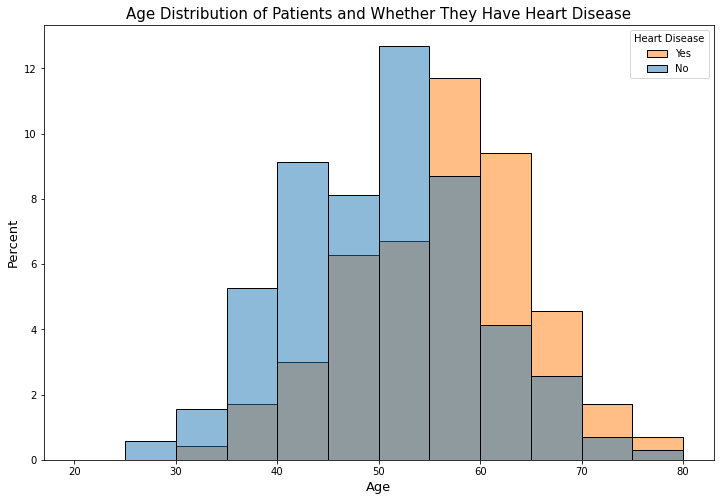

In [10]:
plt.figure(figsize = (12,8))
sns.histplot(data = df, x = 'Age', hue = 'HeartDisease', bins = np.arange(20, 81, 5), stat = 'percent')
plt.xlabel('Age', fontsize = 13)
plt.ylabel('Percent', fontsize = 13)
plt.title('Age Distribution of Patients and Whether They Have Heart Disease', fontsize = 15)
plt.legend(title = 'Heart Disease', labels = ['Yes', 'No']);

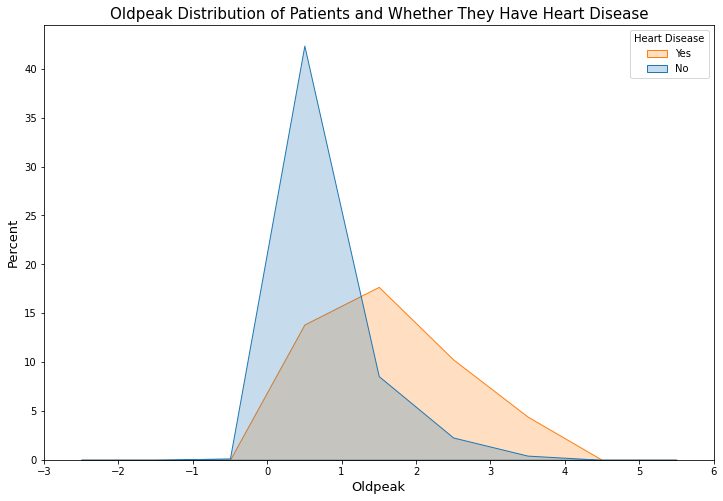

In [11]:
plt.figure(figsize = (12,8))
sns.histplot(data = df, x = 'Oldpeak', hue = 'HeartDisease', bins = np.arange(-3,7,1), stat = 'percent', element = 'poly');
plt.xticks(np.arange(-3,7,1));
plt.xlabel('Oldpeak', fontsize = 13)
plt.ylabel('Percent', fontsize = 13)
plt.title('Oldpeak Distribution of Patients and Whether They Have Heart Disease', fontsize = 15)
plt.legend(title = 'Heart Disease', labels = ['Yes', 'No']);

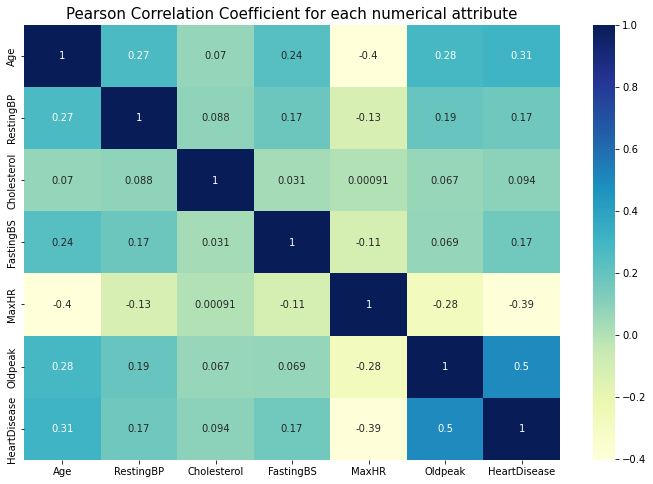

In [12]:
plt.figure(figsize = (12,8))
plt.title('Pearson Correlation Coefficient for each numerical attribute', fontsize = 15)
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);

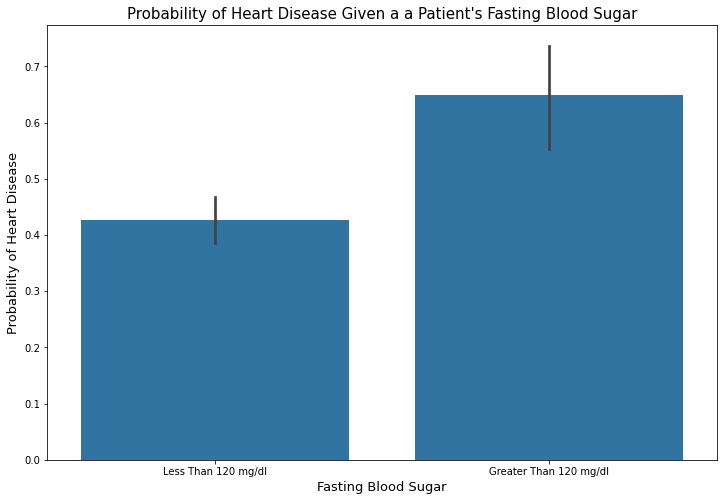

In [13]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = df, x = 'FastingBS', y = 'HeartDisease', color = sns.color_palette()[0])

plt.xlabel('Fasting Blood Sugar', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given a a Patient\'s Fasting Blood Sugar', fontsize = 15)
ax.set_xticklabels(['Less Than 120 mg/dl', 'Greater Than 120 mg/dl']);

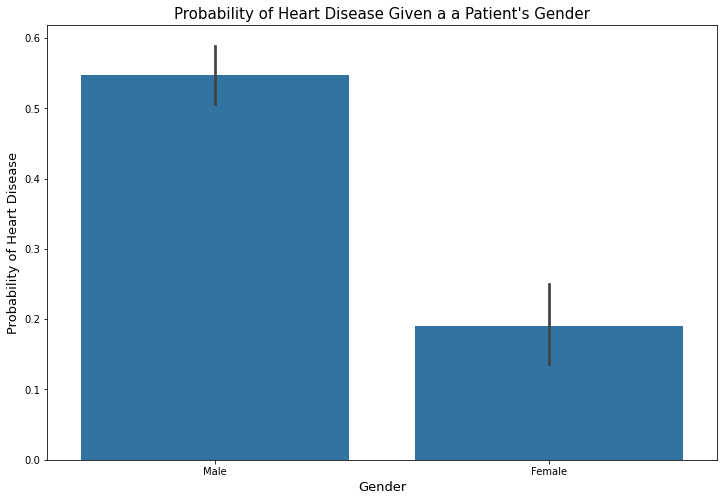

In [14]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = df, x = 'Sex', y = 'HeartDisease', color = sns.color_palette()[0])
plt.xlabel('Gender', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given a a Patient\'s Gender', fontsize = 15)
ax.set_xticklabels(['Male', 'Female']);

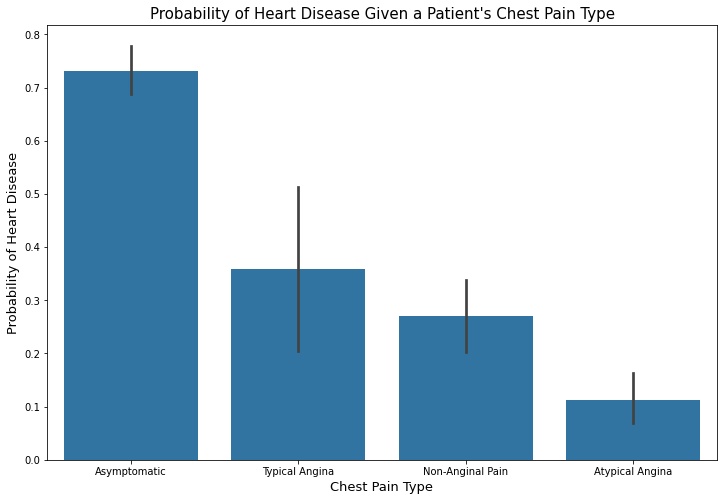

In [15]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = df, x = 'ChestPainType', y = 'HeartDisease', order = ['ASY', 'TA', 'NAP', 'ATA'] ,color = sns.color_palette()[0]);

plt.xlabel('Chest Pain Type', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given a Patient\'s Chest Pain Type', fontsize = 15)

ax.set_xticklabels(['Asymptomatic', 'Typical Angina', 'Non-Anginal Pain', 'Atypical Angina']);

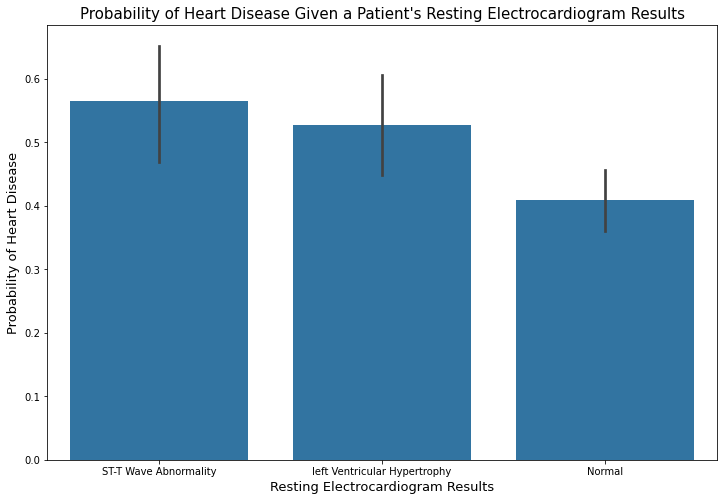

In [16]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = df, x = 'RestingECG', y = 'HeartDisease', order = ['ST', 'LVH', 'Normal'], color = sns.color_palette()[0])
plt.xlabel('Resting Electrocardiogram Results', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given a Patient\'s Resting Electrocardiogram Results', fontsize = 15)

ax.set_xticklabels(['ST-T Wave Abnormality', 'left Ventricular Hypertrophy', 'Normal']);

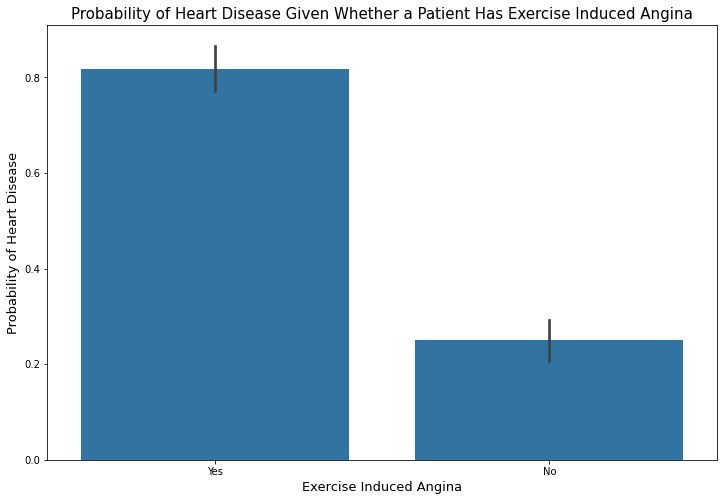

In [17]:
plt.figure(figsize = (12,8))
ax = sns.barplot(data = df, x = 'ExerciseAngina', y = 'HeartDisease', order = ['Y', 'N'], color = sns.color_palette()[0])
plt.xlabel('Exercise Induced Angina', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given Whether a Patient Has Exercise Induced Angina', fontsize = 15)

ax.set_xticklabels(['Yes', 'No']);

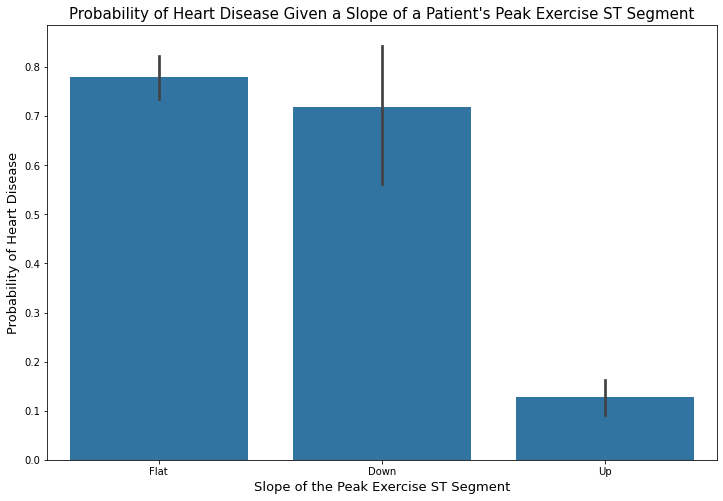

In [18]:
plt.figure(figsize = (12,8))
sns.barplot(data = df, x = 'ST_Slope', y = 'HeartDisease', order = ['Flat', 'Down', 'Up'], color = sns.color_palette()[0]);
plt.xlabel('Slope of the Peak Exercise ST Segment', fontsize = 13)
plt.ylabel('Probability of Heart Disease', fontsize = 13)
plt.title('Probability of Heart Disease Given a Slope of a Patient\'s Peak Exercise ST Segment', fontsize = 15);

In [19]:
df_male = df[df['Sex'] == 'M']['HeartDisease']

In [20]:
df_female = df[df['Sex'] == 'F']['HeartDisease']

In [21]:
df_gender = df[['Sex', 'HeartDisease']]

In [22]:
bootstrapped_gender = [df_gender.sample(n = len(df_gender), replace=True) for _ in range(10000)]

In [23]:
gender_vals = np.array([test[test.Sex == 'M'].HeartDisease.mean() - test[test.Sex == 'F'].HeartDisease.mean() for test in bootstrapped_gender])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


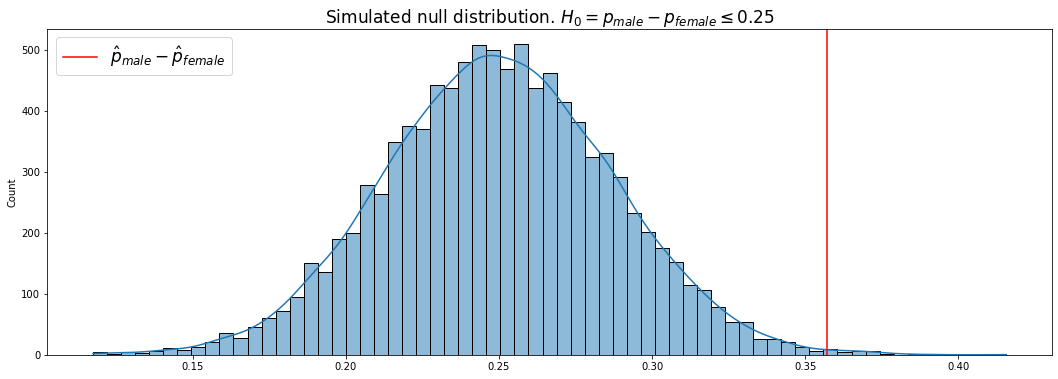

In [24]:
plt.figure(figsize = (18,6))
gender_null_vals = np.random.normal(0.25, gender_vals.std(), 10000)
ax = sns.histplot(gender_null_vals, kde=True)
plt.title('Simulated null distribution. $H_0 = p_{male} - p_{female} \leq 0.25$', fontsize = 17)
plt.axvline(x=gender_vals.mean(), color = 'red', label = '$\hat{p}_{male} - \hat{p}_{female}$')
plt.legend(loc = 'upper left', fontsize = 17)
#plt.savefig('Report/gfx/testGender.eps');

In [25]:
print('P_Value:', (gender_null_vals > gender_vals.mean()).mean())

P_Value: 0.0029


In [26]:
gender_test = proportions_ztest(count = [df_male.sum(), df_female.sum()], nobs = [df_male.count(), df_female.count()], value = 0.25, alternative = 'larger')
print('Z_Statistic:', gender_test[0],' P_Value:', gender_test[1])

Z_Statistic: 2.433894230396963  P_Value: 0.007468679617265744


In [27]:
# ِAge < 55 vs >= 55
df_age = df[['Age', 'HeartDisease']]
df_young = df[df['Age'] < 55]['HeartDisease']
df_old = df[df['Age'] >= 55]['HeartDisease']

In [28]:
bootstrapped_age = [df_age.sample(n = len(df_age), replace=True) for _ in range(10000)]

In [29]:
age_vals = np.array([test[test['Age'] >= 55].HeartDisease.mean() - test[test['Age'] < 55].HeartDisease.mean() for test in bootstrapped_age])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


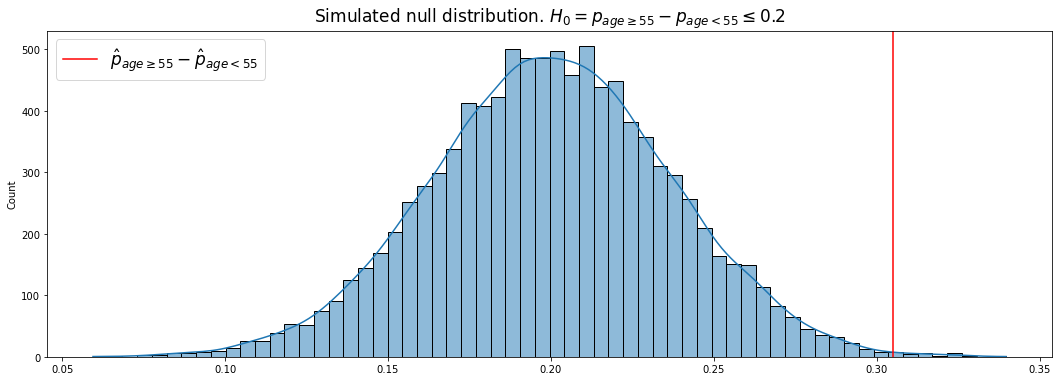

In [30]:
plt.figure(figsize = (18,6))
age_null_vals = np.random.normal(0.2, age_vals.std(), 10000)
ax = sns.histplot(age_null_vals, kde=True)
plt.title('Simulated null distribution. $H_0 = p_{age\geq55} - p_{age<55} \leq 0.2$', fontsize = 17)
plt.axvline(x=age_vals.mean(), color = 'red', label = '$\hat{p}_{age\geq55} - \hat{p}_{age<55}$')
plt.legend(fontsize = 17)
#plt.savefig('Report/gfx/testAge.eps');

In [31]:
print('P_Value:', (age_null_vals > age_vals.mean()).mean())

P_Value: 0.0025


In [32]:
age_test = proportions_ztest(count = [df_old.sum(), df_young.sum()], nobs = [df_old.count(), df_young.count()], value = 0.2, alternative = 'larger')
print('Z_Statistic:', age_test[0],' P_Value:', age_test[1])

Z_Statistic: 2.7693402712394684  P_Value: 0.0028084969211675396


In [33]:
peak_df = df[['Oldpeak', 'HeartDisease']]

In [34]:
bootstrapped_oldpeak = [peak_df.sample(n = len(peak_df), replace = True) for _ in range(10000)]

In [35]:
oldpeak_vals = np.array([test[test.Oldpeak > 1.5].HeartDisease.mean() for test in bootstrapped_oldpeak])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


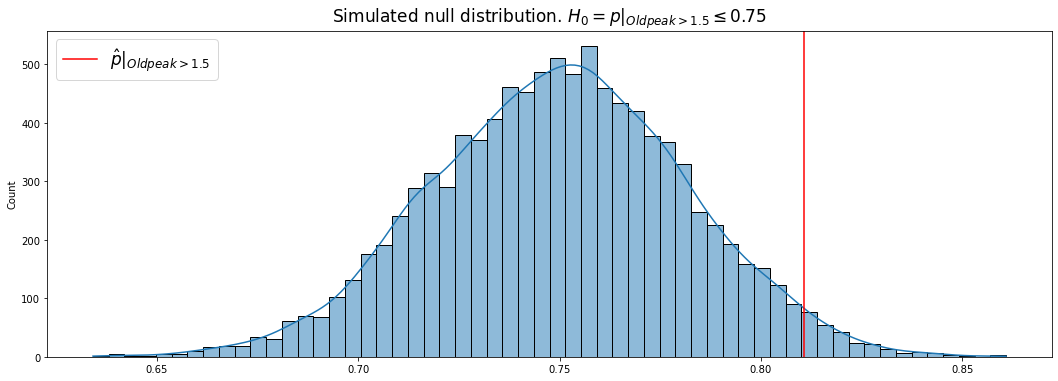

In [36]:
plt.figure(figsize = (18,6))
oldpeak_null_vals = np.random.normal(0.75, oldpeak_vals.std(), 10000)
sns.histplot(oldpeak_null_vals, kde=True)
plt.title('Simulated null distribution. $H_0 = p |_{Oldpeak>1.5} \leq 0.75$', fontsize = 17)
plt.axvline(x=oldpeak_vals.mean(), color = 'red', label = '$\hat{p}|_{Oldpeak>1.5}$')
plt.legend(loc = 'upper left', fontsize = 17)
#plt.savefig('Report/gfx/testOldpeak.eps');

In [37]:
print('P_Value:', (oldpeak_null_vals > oldpeak_vals.mean()).mean())

P_Value: 0.0245


In [38]:
oldpeak_test = ztest(x1 = df[df.Oldpeak > 1.5].HeartDisease, value = 0.75, alternative = 'larger')
print('Z_Statistic:', oldpeak_test[0],' P_Value:', oldpeak_test[1])

Z_Statistic: 1.9700519412347473  P_Value: 0.024416209002946967


In [39]:
# encoding categorical data

labelencoder_x = LabelEncoder()
x[:,1]=labelencoder_x.fit_transform(x[:,1])
x[:,2]=labelencoder_x.fit_transform(x[:,2])
x[:,6]=labelencoder_x.fit_transform(x[:,6])
x[:,8]=labelencoder_x.fit_transform(x[:,8])
x[:,10]=labelencoder_x.fit_transform(x[:,10])


In [40]:
onehotencoder = OneHotEncoder()
columnTransformer1 = ColumnTransformer([('encoder', OneHotEncoder(), [2])], remainder = 'passthrough')
x = np.array(columnTransformer1.fit_transform(x), dtype = np.float64)

# dummy variable
x = np.delete(x,3,1)

onehotencoder = OneHotEncoder()
columnTransformer1 = ColumnTransformer([('encoder', OneHotEncoder(), [7])], remainder = 'passthrough')
x = np.array(columnTransformer1.fit_transform(x), dtype = np.float64)

# dummy variable
x = np.delete(x,1,1)

onehotencoder = OneHotEncoder()
columnTransformer1 = ColumnTransformer([('encoder', OneHotEncoder(), [12])], remainder = 'passthrough')
x = np.array(columnTransformer1.fit_transform(x), dtype = np.float64)

# dummy variable
x = np.delete(x,1,1)

In [41]:
#feature scaling
#make it random or not??
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state = 42)

In [42]:
# Do we need to scale all features ?
Sc_x=StandardScaler()
X_train=Sc_x.fit_transform(x_train)
X_test=Sc_x.transform(x_test)

In [43]:
# Training the Naive Bayes model on the Training set
classifier1 = GaussianNB()
classifier1.fit(X_train, y_train)


GaussianNB()

In [44]:
# Predicting the Train set results
y_train_pred_bayes = classifier1.predict(X_train)
accuracy_Train_bayes =accuracy_score(y_train, y_train_pred_bayes)
cm1 = confusion_matrix(y_train, y_train_pred_bayes)
print("accuracy_Train_bayes = ",accuracy_Train_bayes)
print("Confusion Matrix = ",cm1)

accuracy_Train_bayes =  0.8410714285714286
Confusion Matrix =  [[266  44]
 [ 45 205]]


In [45]:
# Predicting the Test set results
y_pred_test_bayes = classifier1.predict(X_test)
accuracy_Test_bayes = accuracy_score(y_test, y_pred_test_bayes)
cm2 = confusion_matrix(y_test, y_pred_test_bayes)
print("accuracy_Test_bayes = ",accuracy_Test_bayes)
print("Confusion Matrix = ",cm2)

accuracy_Test_bayes =  0.8581560283687943
Confusion Matrix =  [[57 10]
 [10 64]]


(560, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


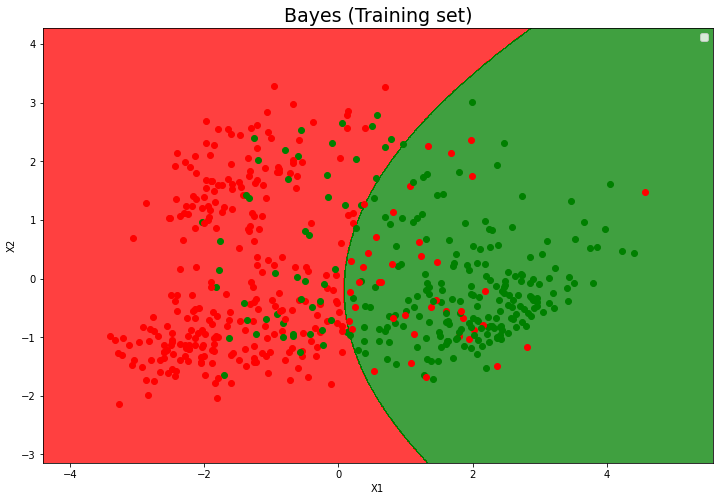

In [46]:
# Visualising the Training set results

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train)
classifier4 = GaussianNB()
classifier4.fit(Xreduced, y_train)

X_set, y_set = Xreduced, y_train
y_set = y_set.reshape((-1,1))
print(y_set.shape)
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01),)
plt.figure(figsize = (12,8))
plt.contourf(X1, X2, classifier4.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())


for i in range (y_set.shape[0]):
    if(y_set[i] == 0):
         plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'red')
        
    else:
        plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'green')


plt.title('Bayes (Training set)', fontsize = 19)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
#plt.savefig('Report/gfx/bayes_train.eps');

(141, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


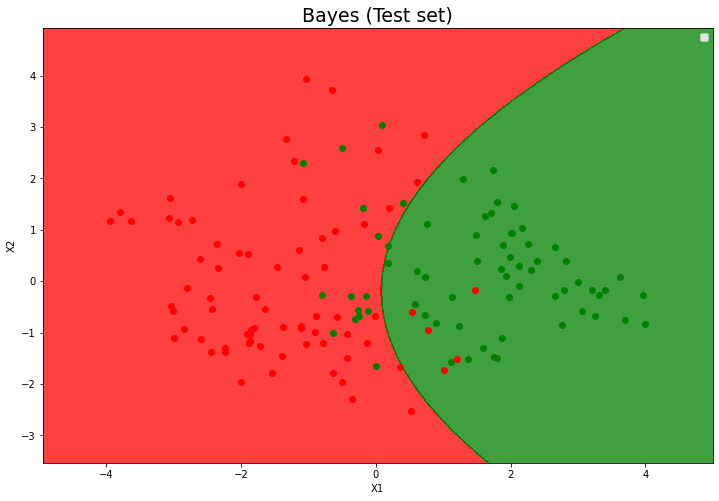

In [47]:
# Visualising the Training set results
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_test)

X_set, y_set = Xreduced, y_test
y_set = y_set.reshape((-1,1))
print(y_set.shape)
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01),)
plt.figure(figsize = (12,8))
plt.contourf(X1, X2, classifier4.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())


for i in range (y_set.shape[0]):
    if(y_set[i] == 1):
         plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'red')
        
    else:
        plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'green')
        
plt.title('Bayes (Test set)', fontsize = 19)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
#plt.savefig('Report/gfx/bayes_test.eps');

In [48]:
classifier2 = SVC(kernel = 'rbf', random_state = 0)
classifier2.fit(X_train, y_train)


SVC(random_state=0)

In [49]:
# Predicting the Test set results
y_train_pred_svm = classifier2.predict(X_train)
from sklearn.metrics import accuracy_score
accuracy_Train_SVM =accuracy_score(y_train, y_train_pred_svm)
# Making the Confusion Matrix
print("accuracy_Train_SVM = ",accuracy_Train_SVM)
cm3 = confusion_matrix(y_train, y_train_pred_svm)
print("Confusion Matrix")
print(cm3)

accuracy_Train_SVM =  0.8982142857142857
Confusion Matrix
[[278  32]
 [ 25 225]]


In [50]:
# Predicting the Test set results
y_pred_test_svm = classifier2.predict(X_test)
accuracy_Test_SVM=accuracy_score(y_test, y_pred_test_svm)
print("accuracy_Test_SVM = ",accuracy_Test_SVM)
# Making the Confusion Matrix
cm4 = confusion_matrix(y_test, y_pred_test_svm)
print("Confusion Matrix")
print(cm4)

accuracy_Test_SVM =  0.8936170212765957
Confusion Matrix
[[58  9]
 [ 6 68]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


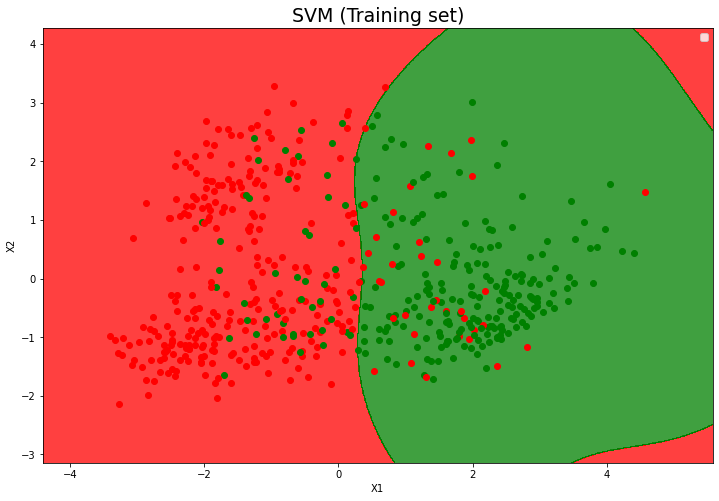

In [51]:
# Visualising the Training set results
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train)
classifier3 = SVC(kernel = 'rbf', random_state = 0)
classifier3.fit(Xreduced, y_train)

X_set, y_set = Xreduced, y_train
y_set = y_set.reshape((-1,1))
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01),)
plt.figure(figsize = (12,8))
plt.contourf(X1, X2, classifier3.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())


for i in range (y_set.shape[0]):
    if(y_set[i] == 0):
         plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'red')
        
    else:
        plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'green')
        
plt.title('SVM (Training set)', fontsize = 19)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
#plt.savefig('Report/gfx/svm_train.eps');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


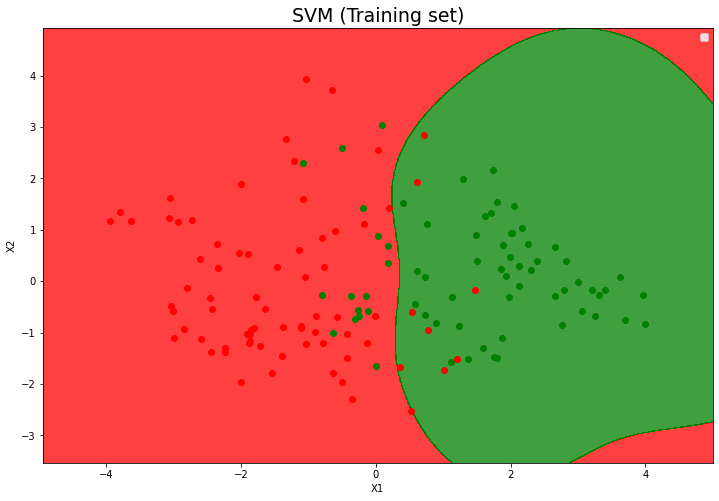

In [52]:
# Visualising the Training set results
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_test)
X_set, y_set = Xreduced, y_test
y_set = y_set.reshape((-1,1))

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01),)
plt.figure(figsize = (12,8))
plt.contourf(X1, X2, classifier3.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())


for i in range (y_set.shape[0]):
    if(y_set[i] == 1):
         plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'red')
        
    else:
        plt.scatter(X_set[i, 0], X_set[i, 1],
                c = 'green')
        
plt.title('SVM (Training set)', fontsize = 19)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
#plt.savefig('Report/gfx/svm_test.eps');

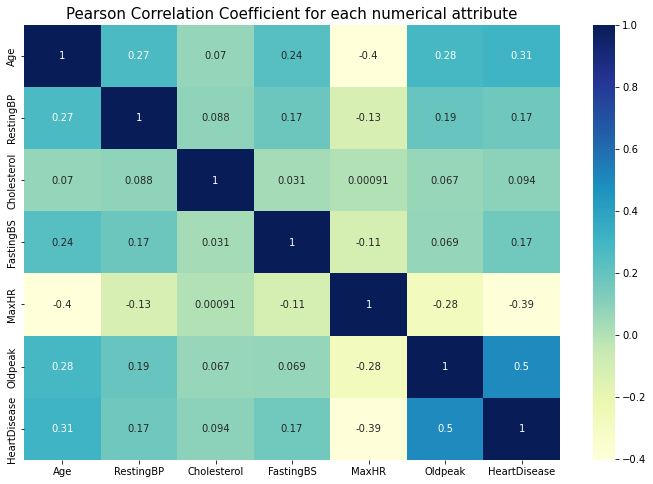

In [53]:
plt.figure(figsize = (12,8))
plt.title('Pearson Correlation Coefficient for each numerical attribute', fontsize = 15)
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
#plt.savefig('Report/gfx/heatmap.eps');

In [54]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

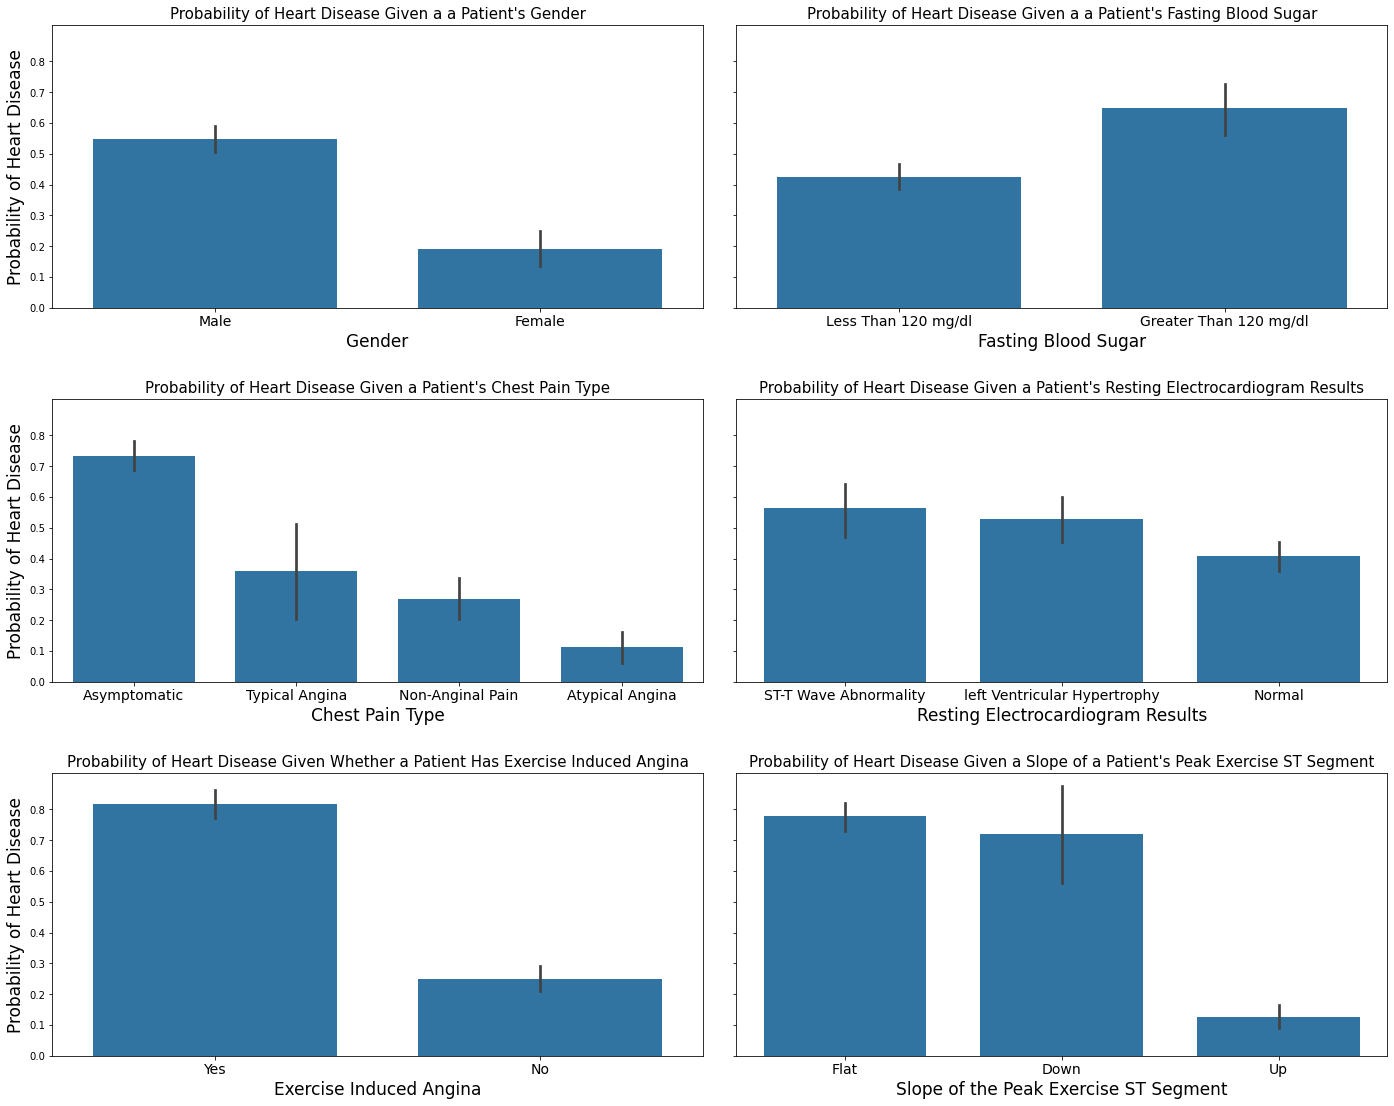

In [55]:
fig, ax = plt.subplots(3, 2, figsize = (20,16), sharey = True, sharex = False)

sns.barplot(data = df, x = 'Sex', y = 'HeartDisease', color = sns.color_palette()[0], ax = ax[0][0])
ax[0][0].set_xlabel('Gender', fontsize = 17)
ax[0][0].set_ylabel('Probability of Heart Disease', fontsize = 17)
ax[0][0].set_title('Probability of Heart Disease Given a a Patient\'s Gender', fontsize = 15)
ax[0][0].set_xticklabels(['Male', 'Female'], fontsize = 14);
ax[0][0].set_yticks(np.arange(0, 0.85, 0.1))

sns.barplot(data = df, x = 'FastingBS', y = 'HeartDisease', color = sns.color_palette()[0], ax = ax[0][1])
ax[0][1].set_xlabel('Fasting Blood Sugar', fontsize = 17)
ax[0][1].set_ylabel('', fontsize = 17)
ax[0][1].set_title('Probability of Heart Disease Given a a Patient\'s Fasting Blood Sugar', fontsize = 15)
ax[0][1].set_xticklabels(['Less Than 120 mg/dl', 'Greater Than 120 mg/dl'], fontsize = 14);

sns.barplot(data = df, x = 'ChestPainType', y = 'HeartDisease', order = ['ASY', 'TA', 'NAP', 'ATA'] ,color = sns.color_palette()[0], ax = ax[1][0]);
ax[1][0].set_xlabel('Chest Pain Type', fontsize = 17)
ax[1][0].set_ylabel('Probability of Heart Disease', fontsize = 17)
ax[1][0].set_title('Probability of Heart Disease Given a Patient\'s Chest Pain Type', fontsize = 15)
ax[1][0].set_xticklabels(['Asymptomatic', 'Typical Angina', 'Non-Anginal Pain', 'Atypical Angina'], fontsize = 14);

sns.barplot(data = df, x = 'RestingECG', y = 'HeartDisease', order = ['ST', 'LVH', 'Normal'], color = sns.color_palette()[0], ax = ax[1][1])
ax[1][1].set_xlabel('Resting Electrocardiogram Results', fontsize = 17)
ax[1][1].set_ylabel('', fontsize = 17)
ax[1][1].set_title('Probability of Heart Disease Given a Patient\'s Resting Electrocardiogram Results', fontsize = 15)
ax[1][1].set_xticklabels(['ST-T Wave Abnormality', 'left Ventricular Hypertrophy', 'Normal'], fontsize = 14);

sns.barplot(data = df, x = 'ExerciseAngina', y = 'HeartDisease', order = ['Y', 'N'], color = sns.color_palette()[0], ax = ax[2][0])
ax[2][0].set_xlabel('Exercise Induced Angina', fontsize = 17)
ax[2][0].set_ylabel('Probability of Heart Disease', fontsize = 17)
ax[2][0].set_title('Probability of Heart Disease Given Whether a Patient Has Exercise Induced Angina', fontsize = 15)
ax[2][0].set_xticklabels(['Yes', 'No'], fontsize = 14);

sns.barplot(data = df, x = 'ST_Slope', y = 'HeartDisease', order = ['Flat', 'Down', 'Up'], color = sns.color_palette()[0], ax = ax[2][1]);
ax[2][1].set_xlabel('Slope of the Peak Exercise ST Segment', fontsize = 17)
ax[2][1].set_ylabel('', fontsize = 17)
ax[2][1].set_title('Probability of Heart Disease Given a Slope of a Patient\'s Peak Exercise ST Segment', fontsize = 15)
ax[2][1].set_xticklabels(['Flat', 'Down', 'Up'], fontsize = 14);

change_width(ax[0][0], 0.75)
change_width(ax[0][1], 0.75)
change_width(ax[1][0], 0.75)
change_width(ax[1][1], 0.75)
change_width(ax[2][0], 0.75)
change_width(ax[2][1], 0.75)
fig.tight_layout(pad=3.0)
#plt.savefig('Report/gfx/max_estimates.eps')